<a href="https://colab.research.google.com/github/AnnabelHall/QCES_LNM/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

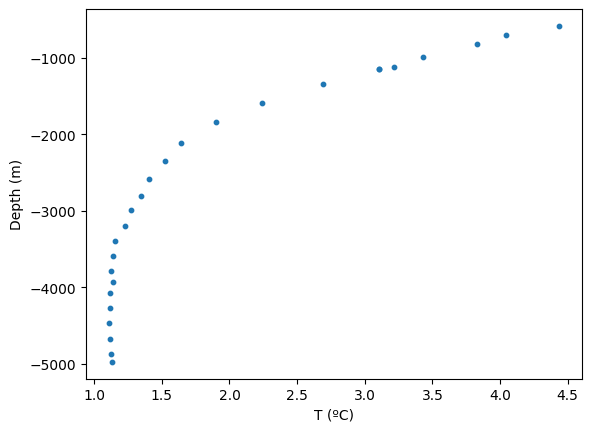

In [ ]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+00/s


2024-11-01 17:15:43,779 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+00/s


Text(0, 0.5, 'Depth (m)')

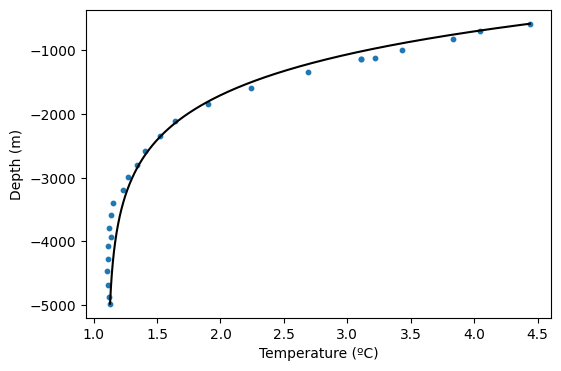

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=8.5e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

**My answer**

Keeping the value of w the same as 1e-7. With some different attempts, I chose a $\kappa$ value of 8.5e-5. This fits the model imperfectly, however follows the graph as a whole. We see the needed 'slowing growth' form, with gradient changing from initially high and then tending towards horizontal. It fails at points as the curve has its major curve point at a higher value of T and D. Nonetheless, this proves to be a good approximation overall.

This diffusivity is approximately 1000 times greater than the original set value of 1e-7.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-11-01 17:15:44,546 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


Text(0, 0.5, 'Depth (m)')

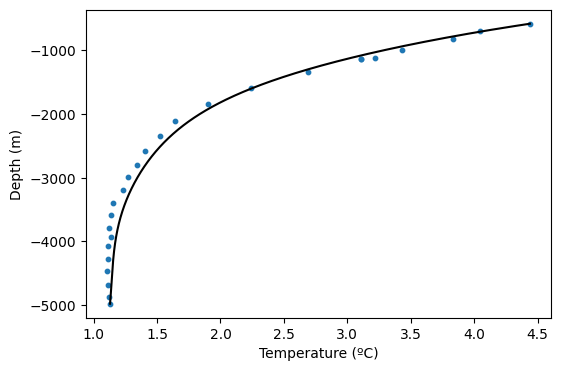

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-5-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

**My Answer**

A value of 0 for $w$ means that there is no vertical velocity, and therefore all changes in temperature with depth are due to turbulence and, on a small level, molecular diffusion. This model fit the data fairly well, although will overestimate temperature at a given depth by up to 0.5 degrees.

First, we try varying the value of w(z). A value of w = 8e-9 m/s produces an excellent fit. At worst, it over/underestimates the T by ~0.1 degrees.

Now, we try different values within the $\kappa(z)$ expression and see how they affect optimal $w$.

| state | $\kappa_{bg}$ | $\kappa_0$ | Optimal $w$ |comment|
| ------|---------------|------------|--------------|-------|
|Original| 1e-5 | 8.6e-4 | 8e-9 | Fits the data well as described above |
| 1 | 1e-4 | 8.6e-4 | 1e-7 | Increasing the value of $\kappa_{bg}$ requires a much higher value of $w$. This can be rationalised as a greater backgroud diffusivity requires more upwelling to balance it.|
| 2 | 1e-5 | 8.6e-5 |1e-8 |  Decreasing the value of $\kappa_0$ also requires a greater value of $w$. With less turbulence at depth, there is less of a difference between deep and surface $\kappa$. Therefore, greater vertical velocity is needed to gain the needed T curve.  |

The interesting variation between $\kappa$ and $w$ can be attributed to the complex relation between them. This can be seen in the graph below.



Text(0, 0.5, 'Depth (m)')

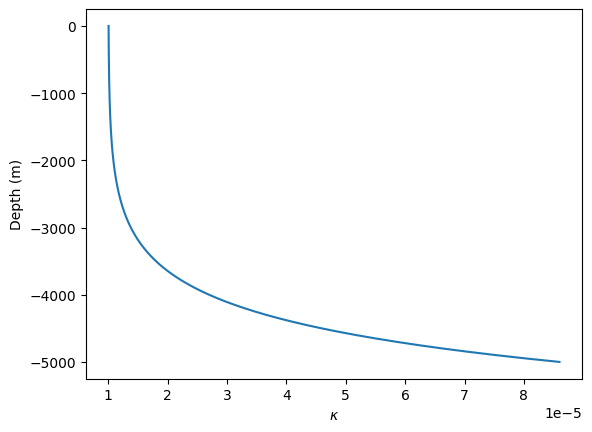

In [ ]:
def kappa_time(z):
  kappa_nums=1e-5 + (8.6e-5-1e-5)*np.exp((-5e3-z)/667) # m^2/s
  return kappa_nums

depths = np.linspace(-5000,0,1000)

plt.plot(kappa_time(depths),depths)

plt.xlabel('$\kappa$')
plt.ylabel('Depth (m)')


## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a time-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s       - CHANGE THIS
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s           - CHANGE THIS
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2024-11-01 17:15:45,699 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:__main__:Starting main loop


2024-11-01 17:15:45,707 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-11-01 17:15:46,380 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-11-01 17:15:46,418 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-11-01 17:15:46,459 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-11-01 17:15:46,501 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-11-01 17:15:46,544 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-11-01 17:15:46,588 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-11-01 17:15:46,633 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-11-01 17:15:46,675 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-11-01 17:15:46,715 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-11-01 17:15:46,755 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-11-01 17:15:46,819 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-11-01 17:15:46,873 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-11-01 17:15:46,922 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-11-01 17:15:46,966 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-11-01 17:15:47,000 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-11-01 17:15:47,032 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-11-01 17:15:47,062 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-11-01 17:15:47,090 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-11-01 17:15:47,118 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-11-01 17:15:47,148 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-11-01 17:15:47,186 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-11-01 17:15:47,222 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-11-01 17:15:47,250 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-11-01 17:15:47,283 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-11-01 17:15:47,312 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-11-01 17:15:47,362 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-11-01 17:15:47,405 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-11-01 17:15:47,448 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-11-01 17:15:47,492 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-11-01 17:15:47,534 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-11-01 17:15:47,582 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-11-01 17:15:47,643 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-11-01 17:15:47,693 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-11-01 17:15:47,738 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-11-01 17:15:47,803 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-11-01 17:15:47,842 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-11-01 17:15:47,881 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-11-01 17:15:47,921 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-11-01 17:15:47,961 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-11-01 17:15:47,998 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-11-01 17:15:48,034 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-11-01 17:15:48,069 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-11-01 17:15:48,098 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-11-01 17:15:48,126 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-11-01 17:15:48,156 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-11-01 17:15:48,184 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-11-01 17:15:48,212 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-11-01 17:15:48,275 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-11-01 17:15:48,363 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-11-01 17:15:48,405 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-11-01 17:15:48,451 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-11-01 17:15:48,504 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-11-01 17:15:48,553 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-11-01 17:15:48,600 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-11-01 17:15:48,648 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-11-01 17:15:48,702 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-11-01 17:15:48,752 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-11-01 17:15:48,840 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-11-01 17:15:48,974 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-11-01 17:15:49,138 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-11-01 17:15:49,193 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-11-01 17:15:49,239 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-11-01 17:15:49,286 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-11-01 17:15:49,337 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-11-01 17:15:49,405 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-11-01 17:15:49,450 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-11-01 17:15:49,533 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-11-01 17:15:49,584 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-11-01 17:15:49,640 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-11-01 17:15:49,762 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-11-01 17:15:49,856 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-11-01 17:15:49,913 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-11-01 17:15:49,976 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-11-01 17:15:50,047 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-11-01 17:15:50,111 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-11-01 17:15:50,175 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-11-01 17:15:50,262 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 17:15:50,359 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-11-01 17:15:50,369 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-11-01 17:15:50,378 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 1.053 sec


2024-11-01 17:15:50,382 solvers 0/1 INFO :: Setup time (init - iter 0): 1.053 sec


INFO:solvers:Warmup time (iter 0-10): 0.07391 sec


2024-11-01 17:15:50,385 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07391 sec


INFO:solvers:Run time (iter 10-end): 3.955 sec


2024-11-01 17:15:50,389 solvers 0/1 INFO :: Run time (iter 10-end): 3.955 sec


INFO:solvers:CPU time (iter 10-end): 0.001099 cpu-hr


2024-11-01 17:15:50,392 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001099 cpu-hr


INFO:solvers:Speed: 3.323e+06 mode-stages/cpu-sec


2024-11-01 17:15:50,394 solvers 0/1 INFO :: Speed: 3.323e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-01 18:41:49,602 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp39bvsl9k/temp.m4v


2024-11-01 18:41:49,607 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp39bvsl9k/temp.m4v


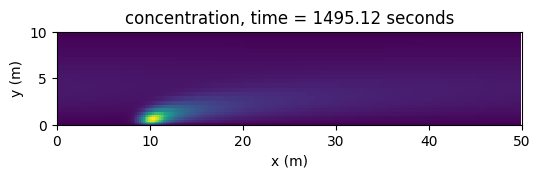

In [26]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

**My Answer**

Below there are two plots showing how concentration varies with time at given points along the river. The first is fairly far down the river, and near its midpoint. The second is near the start of the river, and at the midpoint. The first plot shows a greater magnitude overall, as advection carries the tracer away from start point rapidly. We also see a shift in the first inflection point, where the central point experiences greater concentrations at a later time.

Here, maximum flow speed is 0.1 and $\kappa$ is 1e-2.


Text(0.5, 1.0, 'Concentration variation with time at 23.4m length, and 3.1m width')

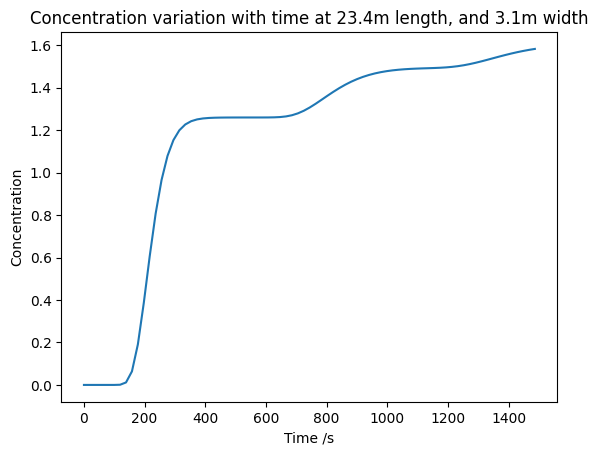

In [ ]:
# Nx = 256 - number of gridoints in x. x is length of river.
# Ny = 32 - number of gridpoints in y. y is width of river.
# the [] after c_save describe the concentration at about 2/5 along the river's length
# and about 1/3 along the river's width

x_bit = 120
y_bit = 10
length_bit = x_bit/256 * L
width_bit = y_bit/32 * w

plt.plot(t_save, c_save[:,x_bit,y_bit])
plt.xlabel('Time /s')
plt.ylabel('Concentration')

title = f'Concentration variation with time at {round(length_bit,1)}m length, and {round(width_bit,1)}m width'
plt.title(title)

Text(0.5, 1.0, 'Concentration variation with time at 2.0m length, and 5.0m width')

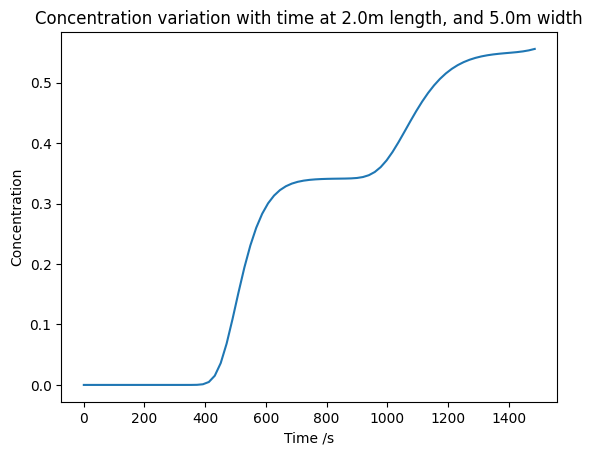

In [ ]:
x_bit = 10
y_bit = 16
length_bit = x_bit/256 * L
width_bit = y_bit/32 * w

plt.plot(t_save, c_save[:,x_bit,y_bit])
plt.xlabel('Time /s')
plt.ylabel('Concentration')

title = f'Concentration variation with time at {round(length_bit,1)}m length, and {round(width_bit,1)}m width'
plt.title(title)

**My Answer - continued**

Now, we vary the maximum flow speed and diffusivity. The original value has $U_0$ = 0.1 and $\kappa$ = 1e-2. Below, I vary both values to smaller and greater values, with the middle plot showing the original set up.

In the original set up, at this point in the river, we see a maximum concentration of 2. Increasing $U_0$ does not affect the magnitude of final concentration, but produces a more turbulent path. The lowest $U_0$ has a smooth increase due to this lower turbulence.

An increase in $\kappa$ has a more pronounced effect. Doubling $\kappa$ will almost double concentration between scenarios, and vice versa for halving. This is to be expected as with a greater $\kappa$, diffusion is stronger and so more tracer will get to the end of the river. The shape of the concentration curve at a given $U_0$ is maintained for different $\kappa$s, however amplitude is increased for greater $\kappa$ and vice versa.



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2024-11-01 18:01:56,250 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:01:56,258 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-11-01 18:01:56,293 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-11-01 18:01:56,321 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-11-01 18:01:56,347 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-11-01 18:01:56,375 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-11-01 18:01:56,403 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-11-01 18:01:56,430 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-11-01 18:01:56,458 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-11-01 18:01:56,485 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-11-01 18:01:56,513 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-11-01 18:01:56,540 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-11-01 18:01:56,568 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-11-01 18:01:56,599 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-11-01 18:01:56,629 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-11-01 18:01:56,659 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-11-01 18:01:56,686 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-11-01 18:01:56,715 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-11-01 18:01:56,751 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-11-01 18:01:56,791 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-11-01 18:01:56,834 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-11-01 18:01:56,868 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-11-01 18:01:56,902 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-11-01 18:01:56,938 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-11-01 18:01:56,974 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-11-01 18:01:57,007 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-11-01 18:01:57,041 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-11-01 18:01:57,076 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-11-01 18:01:57,110 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-11-01 18:01:57,137 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-11-01 18:01:57,163 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-11-01 18:01:57,190 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-11-01 18:01:57,218 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-11-01 18:01:57,248 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-11-01 18:01:57,274 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-11-01 18:01:57,300 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-11-01 18:01:57,327 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-11-01 18:01:57,355 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-11-01 18:01:57,381 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-11-01 18:01:57,408 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-11-01 18:01:57,434 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 18:01:57,447 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-11-01 18:01:57,451 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:01:57,454 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2717 sec


2024-11-01 18:01:57,457 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2717 sec


INFO:solvers:Warmup time (iter 0-10): 0.05274 sec


2024-11-01 18:01:57,459 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05274 sec


INFO:solvers:Run time (iter 10-end): 1.132 sec


2024-11-01 18:01:57,461 solvers 0/1 INFO :: Run time (iter 10-end): 1.132 sec


INFO:solvers:CPU time (iter 10-end): 0.0003145 cpu-hr


2024-11-01 18:01:57,463 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0003145 cpu-hr


INFO:solvers:Speed: 5.728e+06 mode-stages/cpu-sec


2024-11-01 18:01:57,465 solvers 0/1 INFO :: Speed: 5.728e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s


2024-11-01 18:01:57,783 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:01:57,794 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-11-01 18:01:57,850 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-11-01 18:01:57,885 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-11-01 18:01:57,921 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-11-01 18:01:57,956 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-11-01 18:01:57,992 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-11-01 18:01:58,028 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-11-01 18:01:58,062 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-11-01 18:01:58,098 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-11-01 18:01:58,125 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-11-01 18:01:58,156 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-11-01 18:01:58,187 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-11-01 18:01:58,218 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-11-01 18:01:58,245 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-11-01 18:01:58,272 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-11-01 18:01:58,299 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-11-01 18:01:58,326 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-11-01 18:01:58,354 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-11-01 18:01:58,381 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-11-01 18:01:58,408 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-11-01 18:01:58,435 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-11-01 18:01:58,463 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-11-01 18:01:58,492 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-11-01 18:01:58,521 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-11-01 18:01:58,548 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-11-01 18:01:58,577 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-11-01 18:01:58,606 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-11-01 18:01:58,634 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-11-01 18:01:58,667 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-11-01 18:01:58,699 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-11-01 18:01:58,727 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-11-01 18:01:58,766 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-11-01 18:01:58,806 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-11-01 18:01:58,841 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-11-01 18:01:58,892 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-11-01 18:01:58,929 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-11-01 18:01:58,965 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-11-01 18:01:58,999 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-11-01 18:01:59,030 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-11-01 18:01:59,065 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-11-01 18:01:59,099 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-11-01 18:01:59,141 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-11-01 18:01:59,175 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-11-01 18:01:59,201 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-11-01 18:01:59,228 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-11-01 18:01:59,256 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-11-01 18:01:59,283 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-11-01 18:01:59,311 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-11-01 18:01:59,341 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-11-01 18:01:59,368 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-11-01 18:01:59,396 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-11-01 18:01:59,424 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-11-01 18:01:59,451 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-11-01 18:01:59,479 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-11-01 18:01:59,506 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-11-01 18:01:59,533 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-11-01 18:01:59,563 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-11-01 18:01:59,596 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-11-01 18:01:59,624 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-11-01 18:01:59,655 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-11-01 18:01:59,683 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-11-01 18:01:59,714 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-11-01 18:01:59,742 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-11-01 18:01:59,777 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-11-01 18:01:59,817 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-11-01 18:01:59,853 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-11-01 18:01:59,890 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-11-01 18:01:59,935 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-11-01 18:01:59,970 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-11-01 18:02:00,006 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-11-01 18:02:00,041 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-11-01 18:02:00,079 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-11-01 18:02:00,114 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-11-01 18:02:00,143 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-11-01 18:02:00,173 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-11-01 18:02:00,202 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-11-01 18:02:00,232 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-11-01 18:02:00,262 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:00,286 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-11-01 18:02:00,291 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:00,296 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2972 sec


2024-11-01 18:02:00,299 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2972 sec


INFO:solvers:Warmup time (iter 0-10): 0.08069 sec


2024-11-01 18:02:00,302 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08069 sec


INFO:solvers:Run time (iter 10-end): 2.409 sec


2024-11-01 18:02:00,305 solvers 0/1 INFO :: Run time (iter 10-end): 2.409 sec


INFO:solvers:CPU time (iter 10-end): 0.0006692 cpu-hr


2024-11-01 18:02:00,308 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006692 cpu-hr


INFO:solvers:Speed: 5.456e+06 mode-stages/cpu-sec


2024-11-01 18:02:00,310 solvers 0/1 INFO :: Speed: 5.456e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2024-11-01 18:02:00,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:00,632 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2024-11-01 18:02:00,669 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2024-11-01 18:02:00,697 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2024-11-01 18:02:00,725 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2024-11-01 18:02:00,760 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2024-11-01 18:02:00,797 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2024-11-01 18:02:00,832 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2024-11-01 18:02:00,869 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2024-11-01 18:02:00,904 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2024-11-01 18:02:00,948 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2024-11-01 18:02:00,986 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2024-11-01 18:02:01,024 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2024-11-01 18:02:01,059 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2024-11-01 18:02:01,096 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2024-11-01 18:02:01,128 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2024-11-01 18:02:01,157 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2024-11-01 18:02:01,186 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2024-11-01 18:02:01,215 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2024-11-01 18:02:01,245 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2024-11-01 18:02:01,282 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2024-11-01 18:02:01,309 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2024-11-01 18:02:01,338 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2024-11-01 18:02:01,372 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2024-11-01 18:02:01,399 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2024-11-01 18:02:01,428 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2024-11-01 18:02:01,457 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2024-11-01 18:02:01,490 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2024-11-01 18:02:01,518 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2024-11-01 18:02:01,548 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2024-11-01 18:02:01,577 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2024-11-01 18:02:01,611 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2024-11-01 18:02:01,641 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2024-11-01 18:02:01,671 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2024-11-01 18:02:01,702 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2024-11-01 18:02:01,732 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2024-11-01 18:02:01,775 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2024-11-01 18:02:01,817 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2024-11-01 18:02:01,856 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2024-11-01 18:02:01,903 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2024-11-01 18:02:01,939 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2024-11-01 18:02:01,979 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2024-11-01 18:02:02,031 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2024-11-01 18:02:02,067 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2024-11-01 18:02:02,113 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2024-11-01 18:02:02,153 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2024-11-01 18:02:02,194 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2024-11-01 18:02:02,232 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2024-11-01 18:02:02,269 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2024-11-01 18:02:02,305 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2024-11-01 18:02:02,343 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2024-11-01 18:02:02,397 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2024-11-01 18:02:02,441 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2024-11-01 18:02:02,478 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2024-11-01 18:02:02,520 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2024-11-01 18:02:02,570 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2024-11-01 18:02:02,611 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2024-11-01 18:02:02,649 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2024-11-01 18:02:02,696 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2024-11-01 18:02:02,739 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2024-11-01 18:02:02,787 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2024-11-01 18:02:02,829 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2024-11-01 18:02:02,870 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2024-11-01 18:02:02,914 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2024-11-01 18:02:02,963 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2024-11-01 18:02:03,006 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2024-11-01 18:02:03,063 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2024-11-01 18:02:03,105 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2024-11-01 18:02:03,147 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2024-11-01 18:02:03,192 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2024-11-01 18:02:03,232 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2024-11-01 18:02:03,280 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2024-11-01 18:02:03,324 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2024-11-01 18:02:03,361 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2024-11-01 18:02:03,399 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2024-11-01 18:02:03,435 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2024-11-01 18:02:03,471 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2024-11-01 18:02:03,507 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2024-11-01 18:02:03,547 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2024-11-01 18:02:03,586 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2024-11-01 18:02:03,627 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2024-11-01 18:02:03,665 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2024-11-01 18:02:03,711 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2024-11-01 18:02:03,758 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2024-11-01 18:02:03,802 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2024-11-01 18:02:03,843 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2024-11-01 18:02:03,889 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2024-11-01 18:02:03,941 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2024-11-01 18:02:03,995 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2024-11-01 18:02:04,044 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2024-11-01 18:02:04,098 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2024-11-01 18:02:04,152 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2024-11-01 18:02:04,199 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2024-11-01 18:02:04,240 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2024-11-01 18:02:04,279 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2024-11-01 18:02:04,315 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2024-11-01 18:02:04,350 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2024-11-01 18:02:04,387 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2024-11-01 18:02:04,423 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2024-11-01 18:02:04,459 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2024-11-01 18:02:04,502 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2024-11-01 18:02:04,542 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2024-11-01 18:02:04,585 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2024-11-01 18:02:04,624 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2024-11-01 18:02:04,665 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2024-11-01 18:02:04,714 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2024-11-01 18:02:04,764 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2024-11-01 18:02:04,819 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2024-11-01 18:02:04,868 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2024-11-01 18:02:04,930 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2024-11-01 18:02:04,980 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2024-11-01 18:02:05,025 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2024-11-01 18:02:05,063 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2024-11-01 18:02:05,099 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2024-11-01 18:02:05,135 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2024-11-01 18:02:05,186 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2024-11-01 18:02:05,233 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2024-11-01 18:02:05,275 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2024-11-01 18:02:05,316 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2024-11-01 18:02:05,363 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2024-11-01 18:02:05,403 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2024-11-01 18:02:05,448 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2024-11-01 18:02:05,488 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2024-11-01 18:02:05,526 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2024-11-01 18:02:05,570 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2024-11-01 18:02:05,614 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2024-11-01 18:02:05,658 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2024-11-01 18:02:05,700 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2024-11-01 18:02:05,741 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2024-11-01 18:02:05,797 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2024-11-01 18:02:05,843 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2024-11-01 18:02:05,891 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2024-11-01 18:02:05,937 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2024-11-01 18:02:05,983 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2024-11-01 18:02:06,026 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2024-11-01 18:02:06,070 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2024-11-01 18:02:06,112 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2024-11-01 18:02:06,149 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2024-11-01 18:02:06,188 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2024-11-01 18:02:06,238 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2024-11-01 18:02:06,289 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2024-11-01 18:02:06,328 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2024-11-01 18:02:06,371 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2024-11-01 18:02:06,408 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2024-11-01 18:02:06,446 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2024-11-01 18:02:06,483 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2024-11-01 18:02:06,522 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2024-11-01 18:02:06,559 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2024-11-01 18:02:06,600 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2024-11-01 18:02:06,641 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2024-11-01 18:02:06,686 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2024-11-01 18:02:06,728 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2024-11-01 18:02:06,771 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2024-11-01 18:02:06,809 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2024-11-01 18:02:06,847 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2024-11-01 18:02:06,888 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:06,911 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2024-11-01 18:02:06,916 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:06,920 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2802 sec


2024-11-01 18:02:06,923 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2802 sec


INFO:solvers:Warmup time (iter 0-10): 0.05487 sec


2024-11-01 18:02:06,925 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05487 sec


INFO:solvers:Run time (iter 10-end): 6.221 sec


2024-11-01 18:02:06,927 solvers 0/1 INFO :: Run time (iter 10-end): 6.221 sec


INFO:solvers:CPU time (iter 10-end): 0.001728 cpu-hr


2024-11-01 18:02:06,929 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001728 cpu-hr


INFO:solvers:Speed: 4.254e+06 mode-stages/cpu-sec


2024-11-01 18:02:06,931 solvers 0/1 INFO :: Speed: 4.254e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


2024-11-01 18:02:07,802 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:07,808 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-11-01 18:02:07,851 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-11-01 18:02:07,881 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-11-01 18:02:07,911 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-11-01 18:02:07,943 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-11-01 18:02:07,974 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-11-01 18:02:08,007 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-11-01 18:02:08,038 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-11-01 18:02:08,067 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-11-01 18:02:08,102 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-11-01 18:02:08,132 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-11-01 18:02:08,164 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-11-01 18:02:08,196 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-11-01 18:02:08,226 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-11-01 18:02:08,262 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-11-01 18:02:08,296 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-11-01 18:02:08,329 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-11-01 18:02:08,372 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-11-01 18:02:08,406 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-11-01 18:02:08,438 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-11-01 18:02:08,468 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-11-01 18:02:08,504 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-11-01 18:02:08,534 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-11-01 18:02:08,566 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-11-01 18:02:08,598 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-11-01 18:02:08,628 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-11-01 18:02:08,662 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-11-01 18:02:08,696 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-11-01 18:02:08,734 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-11-01 18:02:08,776 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-11-01 18:02:08,814 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-11-01 18:02:08,857 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-11-01 18:02:08,895 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-11-01 18:02:08,934 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-11-01 18:02:08,974 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-11-01 18:02:09,013 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-11-01 18:02:09,051 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-11-01 18:02:09,089 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-11-01 18:02:09,125 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-11-01 18:02:09,169 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:09,185 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-11-01 18:02:09,190 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:09,194 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.8252 sec


2024-11-01 18:02:09,197 solvers 0/1 INFO :: Setup time (init - iter 0): 0.8252 sec


INFO:solvers:Warmup time (iter 0-10): 0.06116 sec


2024-11-01 18:02:09,201 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06116 sec


INFO:solvers:Run time (iter 10-end): 1.311 sec


2024-11-01 18:02:09,204 solvers 0/1 INFO :: Run time (iter 10-end): 1.311 sec


INFO:solvers:CPU time (iter 10-end): 0.0003642 cpu-hr


2024-11-01 18:02:09,207 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0003642 cpu-hr


INFO:solvers:Speed: 4.947e+06 mode-stages/cpu-sec


2024-11-01 18:02:09,210 solvers 0/1 INFO :: Speed: 4.947e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-11-01 18:02:09,596 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:09,603 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-11-01 18:02:09,648 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-11-01 18:02:09,679 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-11-01 18:02:09,715 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-11-01 18:02:09,748 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-11-01 18:02:09,789 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-11-01 18:02:09,831 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-11-01 18:02:09,871 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-11-01 18:02:09,906 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-11-01 18:02:09,938 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-11-01 18:02:09,974 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-11-01 18:02:10,007 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-11-01 18:02:10,041 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-11-01 18:02:10,078 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-11-01 18:02:10,110 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-11-01 18:02:10,144 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-11-01 18:02:10,178 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-11-01 18:02:10,213 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-11-01 18:02:10,246 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-11-01 18:02:10,276 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-11-01 18:02:10,310 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-11-01 18:02:10,346 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-11-01 18:02:10,380 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-11-01 18:02:10,416 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-11-01 18:02:10,463 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-11-01 18:02:10,494 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-11-01 18:02:10,527 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-11-01 18:02:10,558 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-11-01 18:02:10,594 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-11-01 18:02:10,625 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-11-01 18:02:10,662 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-11-01 18:02:10,697 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-11-01 18:02:10,733 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-11-01 18:02:10,774 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-11-01 18:02:10,818 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-11-01 18:02:10,859 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-11-01 18:02:10,893 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-11-01 18:02:10,929 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-11-01 18:02:10,975 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-11-01 18:02:11,014 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-11-01 18:02:11,055 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-11-01 18:02:11,097 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-11-01 18:02:11,136 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-11-01 18:02:11,175 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-11-01 18:02:11,221 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-11-01 18:02:11,259 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-11-01 18:02:11,295 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-11-01 18:02:11,333 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-11-01 18:02:11,364 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-11-01 18:02:11,399 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-11-01 18:02:11,431 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-11-01 18:02:11,472 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-11-01 18:02:11,508 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-11-01 18:02:11,540 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-11-01 18:02:11,574 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-11-01 18:02:11,610 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-11-01 18:02:11,641 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-11-01 18:02:11,678 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-11-01 18:02:11,714 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-11-01 18:02:11,748 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-11-01 18:02:11,790 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-11-01 18:02:11,832 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-11-01 18:02:11,873 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-11-01 18:02:11,912 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-11-01 18:02:11,960 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-11-01 18:02:11,991 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-11-01 18:02:12,026 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-11-01 18:02:12,060 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-11-01 18:02:12,092 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-11-01 18:02:12,129 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-11-01 18:02:12,166 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-11-01 18:02:12,200 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-11-01 18:02:12,234 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-11-01 18:02:12,268 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-11-01 18:02:12,300 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-11-01 18:02:12,333 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-11-01 18:02:12,366 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-11-01 18:02:12,402 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:12,427 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-11-01 18:02:12,431 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:12,437 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3502 sec


2024-11-01 18:02:12,440 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3502 sec


INFO:solvers:Warmup time (iter 0-10): 0.06336 sec


2024-11-01 18:02:12,442 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06336 sec


INFO:solvers:Run time (iter 10-end): 2.754 sec


2024-11-01 18:02:12,444 solvers 0/1 INFO :: Run time (iter 10-end): 2.754 sec


INFO:solvers:CPU time (iter 10-end): 0.000765 cpu-hr


2024-11-01 18:02:12,446 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000765 cpu-hr


INFO:solvers:Speed: 4.772e+06 mode-stages/cpu-sec


2024-11-01 18:02:12,449 solvers 0/1 INFO :: Speed: 4.772e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2024-11-01 18:02:12,851 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:12,858 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2024-11-01 18:02:12,913 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2024-11-01 18:02:12,952 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2024-11-01 18:02:12,992 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2024-11-01 18:02:13,031 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2024-11-01 18:02:13,075 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2024-11-01 18:02:13,108 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2024-11-01 18:02:13,141 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2024-11-01 18:02:13,175 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2024-11-01 18:02:13,212 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2024-11-01 18:02:13,245 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2024-11-01 18:02:13,280 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2024-11-01 18:02:13,313 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2024-11-01 18:02:13,350 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2024-11-01 18:02:13,382 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2024-11-01 18:02:13,418 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2024-11-01 18:02:13,451 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2024-11-01 18:02:13,484 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2024-11-01 18:02:13,520 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2024-11-01 18:02:13,553 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2024-11-01 18:02:13,599 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2024-11-01 18:02:13,633 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2024-11-01 18:02:13,666 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2024-11-01 18:02:13,697 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2024-11-01 18:02:13,731 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2024-11-01 18:02:13,773 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2024-11-01 18:02:13,813 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2024-11-01 18:02:13,863 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2024-11-01 18:02:13,902 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2024-11-01 18:02:13,945 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2024-11-01 18:02:13,987 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2024-11-01 18:02:14,029 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2024-11-01 18:02:14,069 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2024-11-01 18:02:14,110 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2024-11-01 18:02:14,144 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2024-11-01 18:02:14,182 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2024-11-01 18:02:14,213 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2024-11-01 18:02:14,250 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2024-11-01 18:02:14,281 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2024-11-01 18:02:14,319 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2024-11-01 18:02:14,350 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2024-11-01 18:02:14,384 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2024-11-01 18:02:14,418 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2024-11-01 18:02:14,450 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2024-11-01 18:02:14,484 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2024-11-01 18:02:14,516 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2024-11-01 18:02:14,549 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2024-11-01 18:02:14,583 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2024-11-01 18:02:14,631 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2024-11-01 18:02:14,661 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2024-11-01 18:02:14,698 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2024-11-01 18:02:14,736 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2024-11-01 18:02:14,779 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2024-11-01 18:02:14,821 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2024-11-01 18:02:14,869 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2024-11-01 18:02:14,915 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2024-11-01 18:02:14,957 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2024-11-01 18:02:14,996 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2024-11-01 18:02:15,035 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2024-11-01 18:02:15,068 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2024-11-01 18:02:15,102 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2024-11-01 18:02:15,140 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2024-11-01 18:02:15,178 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2024-11-01 18:02:15,211 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2024-11-01 18:02:15,247 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2024-11-01 18:02:15,278 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2024-11-01 18:02:15,311 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2024-11-01 18:02:15,349 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2024-11-01 18:02:15,380 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2024-11-01 18:02:15,418 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2024-11-01 18:02:15,450 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2024-11-01 18:02:15,483 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2024-11-01 18:02:15,519 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2024-11-01 18:02:15,552 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2024-11-01 18:02:15,589 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2024-11-01 18:02:15,627 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2024-11-01 18:02:15,678 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2024-11-01 18:02:15,715 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2024-11-01 18:02:15,748 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2024-11-01 18:02:15,791 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2024-11-01 18:02:15,834 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2024-11-01 18:02:15,881 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2024-11-01 18:02:15,920 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2024-11-01 18:02:15,961 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2024-11-01 18:02:16,004 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2024-11-01 18:02:16,045 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2024-11-01 18:02:16,092 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2024-11-01 18:02:16,128 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2024-11-01 18:02:16,162 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2024-11-01 18:02:16,196 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2024-11-01 18:02:16,229 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2024-11-01 18:02:16,265 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2024-11-01 18:02:16,301 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2024-11-01 18:02:16,338 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2024-11-01 18:02:16,372 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2024-11-01 18:02:16,406 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2024-11-01 18:02:16,443 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2024-11-01 18:02:16,479 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2024-11-01 18:02:16,514 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2024-11-01 18:02:16,549 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2024-11-01 18:02:16,589 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2024-11-01 18:02:16,624 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2024-11-01 18:02:16,657 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2024-11-01 18:02:16,700 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2024-11-01 18:02:16,738 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2024-11-01 18:02:16,783 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2024-11-01 18:02:16,827 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2024-11-01 18:02:16,873 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2024-11-01 18:02:16,915 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2024-11-01 18:02:16,959 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2024-11-01 18:02:17,004 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2024-11-01 18:02:17,047 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2024-11-01 18:02:17,082 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2024-11-01 18:02:17,116 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2024-11-01 18:02:17,151 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2024-11-01 18:02:17,185 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2024-11-01 18:02:17,219 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2024-11-01 18:02:17,256 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2024-11-01 18:02:17,290 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2024-11-01 18:02:17,324 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2024-11-01 18:02:17,358 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2024-11-01 18:02:17,400 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2024-11-01 18:02:17,433 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2024-11-01 18:02:17,473 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2024-11-01 18:02:17,507 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2024-11-01 18:02:17,543 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2024-11-01 18:02:17,578 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2024-11-01 18:02:17,617 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2024-11-01 18:02:17,652 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2024-11-01 18:02:17,688 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2024-11-01 18:02:17,722 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2024-11-01 18:02:17,773 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2024-11-01 18:02:17,824 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2024-11-01 18:02:17,873 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2024-11-01 18:02:17,924 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2024-11-01 18:02:17,980 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2024-11-01 18:02:18,020 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2024-11-01 18:02:18,066 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2024-11-01 18:02:18,111 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2024-11-01 18:02:18,156 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2024-11-01 18:02:18,225 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2024-11-01 18:02:18,270 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2024-11-01 18:02:18,317 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2024-11-01 18:02:18,367 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2024-11-01 18:02:18,414 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2024-11-01 18:02:18,460 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2024-11-01 18:02:18,507 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2024-11-01 18:02:18,551 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2024-11-01 18:02:18,592 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2024-11-01 18:02:18,633 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2024-11-01 18:02:18,683 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2024-11-01 18:02:18,739 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2024-11-01 18:02:18,800 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2024-11-01 18:02:18,853 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2024-11-01 18:02:18,903 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:18,933 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2024-11-01 18:02:18,936 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:18,939 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3656 sec


2024-11-01 18:02:18,945 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3656 sec


INFO:solvers:Warmup time (iter 0-10): 0.08291 sec


2024-11-01 18:02:18,950 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08291 sec


INFO:solvers:Run time (iter 10-end): 5.986 sec


2024-11-01 18:02:18,958 solvers 0/1 INFO :: Run time (iter 10-end): 5.986 sec


INFO:solvers:CPU time (iter 10-end): 0.001663 cpu-hr


2024-11-01 18:02:18,963 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001663 cpu-hr


INFO:solvers:Speed: 4.42e+06 mode-stages/cpu-sec


2024-11-01 18:02:18,969 solvers 0/1 INFO :: Speed: 4.42e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-11-01 18:02:19,533 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:19,538 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-11-01 18:02:19,598 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-11-01 18:02:19,645 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-11-01 18:02:19,692 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-11-01 18:02:19,734 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-11-01 18:02:19,775 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-11-01 18:02:19,830 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-11-01 18:02:19,886 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-11-01 18:02:19,932 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-11-01 18:02:19,985 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-11-01 18:02:20,027 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-11-01 18:02:20,069 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-11-01 18:02:20,107 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-11-01 18:02:20,144 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-11-01 18:02:20,180 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-11-01 18:02:20,216 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-11-01 18:02:20,252 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-11-01 18:02:20,291 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-11-01 18:02:20,329 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-11-01 18:02:20,377 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-11-01 18:02:20,433 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-11-01 18:02:20,483 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-11-01 18:02:20,550 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-11-01 18:02:20,590 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-11-01 18:02:20,642 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-11-01 18:02:20,701 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-11-01 18:02:20,752 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-11-01 18:02:20,812 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-11-01 18:02:20,864 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-11-01 18:02:20,913 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-11-01 18:02:20,960 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-11-01 18:02:21,028 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-11-01 18:02:21,093 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-11-01 18:02:21,155 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-11-01 18:02:21,205 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-11-01 18:02:21,258 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-11-01 18:02:21,308 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-11-01 18:02:21,349 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-11-01 18:02:21,407 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-11-01 18:02:21,449 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:21,468 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-11-01 18:02:21,474 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:21,478 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4918 sec


2024-11-01 18:02:21,483 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4918 sec


INFO:solvers:Warmup time (iter 0-10): 0.09437 sec


2024-11-01 18:02:21,488 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09437 sec


INFO:solvers:Run time (iter 10-end): 1.833 sec


2024-11-01 18:02:21,491 solvers 0/1 INFO :: Run time (iter 10-end): 1.833 sec


INFO:solvers:CPU time (iter 10-end): 0.0005091 cpu-hr


2024-11-01 18:02:21,496 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005091 cpu-hr


INFO:solvers:Speed: 3.539e+06 mode-stages/cpu-sec


2024-11-01 18:02:21,499 solvers 0/1 INFO :: Speed: 3.539e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-11-01 18:02:22,086 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:22,093 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-11-01 18:02:22,152 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-11-01 18:02:22,204 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-11-01 18:02:22,251 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-11-01 18:02:22,302 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-11-01 18:02:22,344 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-11-01 18:02:22,387 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-11-01 18:02:22,428 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-11-01 18:02:22,474 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-11-01 18:02:22,533 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-11-01 18:02:22,573 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-11-01 18:02:22,614 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-11-01 18:02:22,655 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-11-01 18:02:22,696 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-11-01 18:02:22,738 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-11-01 18:02:22,783 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-11-01 18:02:22,829 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-11-01 18:02:22,885 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-11-01 18:02:22,944 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-11-01 18:02:23,002 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-11-01 18:02:23,059 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-11-01 18:02:23,122 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-11-01 18:02:23,164 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-11-01 18:02:23,203 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-11-01 18:02:23,253 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-11-01 18:02:23,303 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-11-01 18:02:23,354 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-11-01 18:02:23,395 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-11-01 18:02:23,449 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-11-01 18:02:23,497 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-11-01 18:02:23,544 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-11-01 18:02:23,604 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-11-01 18:02:23,656 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-11-01 18:02:23,716 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-11-01 18:02:23,773 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-11-01 18:02:23,828 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-11-01 18:02:23,884 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-11-01 18:02:23,937 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-11-01 18:02:24,005 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-11-01 18:02:24,069 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-11-01 18:02:24,122 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-11-01 18:02:24,178 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-11-01 18:02:24,232 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-11-01 18:02:24,291 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-11-01 18:02:24,340 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-11-01 18:02:24,402 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-11-01 18:02:24,463 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-11-01 18:02:24,515 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-11-01 18:02:24,560 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-11-01 18:02:24,608 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-11-01 18:02:24,656 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-11-01 18:02:24,713 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-11-01 18:02:24,756 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-11-01 18:02:24,818 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-11-01 18:02:24,876 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-11-01 18:02:24,927 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-11-01 18:02:24,977 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-11-01 18:02:25,015 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-11-01 18:02:25,051 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-11-01 18:02:25,088 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-11-01 18:02:25,126 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-11-01 18:02:25,180 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-11-01 18:02:25,219 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-11-01 18:02:25,262 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-11-01 18:02:25,309 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-11-01 18:02:25,346 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-11-01 18:02:25,382 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-11-01 18:02:25,420 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-11-01 18:02:25,456 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-11-01 18:02:25,506 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-11-01 18:02:25,548 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-11-01 18:02:25,592 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-11-01 18:02:25,629 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-11-01 18:02:25,665 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-11-01 18:02:25,701 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-11-01 18:02:25,738 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-11-01 18:02:25,784 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-11-01 18:02:25,839 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:25,881 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-11-01 18:02:25,888 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:25,893 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5372 sec


2024-11-01 18:02:25,897 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5372 sec


INFO:solvers:Warmup time (iter 0-10): 0.09431 sec


2024-11-01 18:02:25,901 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09431 sec


INFO:solvers:Run time (iter 10-end): 3.69 sec


2024-11-01 18:02:25,903 solvers 0/1 INFO :: Run time (iter 10-end): 3.69 sec


INFO:solvers:CPU time (iter 10-end): 0.001025 cpu-hr


2024-11-01 18:02:25,907 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001025 cpu-hr


INFO:solvers:Speed: 3.562e+06 mode-stages/cpu-sec


2024-11-01 18:02:25,909 solvers 0/1 INFO :: Speed: 3.562e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-11-01 18:02:26,460 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:__main__:Starting main loop


2024-11-01 18:02:26,471 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2024-11-01 18:02:26,527 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2024-11-01 18:02:26,580 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2024-11-01 18:02:26,624 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2024-11-01 18:02:26,669 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2024-11-01 18:02:26,722 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2024-11-01 18:02:26,772 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2024-11-01 18:02:26,830 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2024-11-01 18:02:26,885 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2024-11-01 18:02:26,938 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2024-11-01 18:02:26,995 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2024-11-01 18:02:27,051 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2024-11-01 18:02:27,099 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2024-11-01 18:02:27,146 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2024-11-01 18:02:27,191 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2024-11-01 18:02:27,238 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2024-11-01 18:02:27,280 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2024-11-01 18:02:27,334 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2024-11-01 18:02:27,381 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2024-11-01 18:02:27,424 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2024-11-01 18:02:27,476 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2024-11-01 18:02:27,520 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2024-11-01 18:02:27,560 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2024-11-01 18:02:27,606 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2024-11-01 18:02:27,658 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2024-11-01 18:02:27,712 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2024-11-01 18:02:27,763 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2024-11-01 18:02:27,817 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2024-11-01 18:02:27,877 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2024-11-01 18:02:27,935 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2024-11-01 18:02:27,999 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2024-11-01 18:02:28,058 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2024-11-01 18:02:28,113 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2024-11-01 18:02:28,152 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2024-11-01 18:02:28,193 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2024-11-01 18:02:28,232 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2024-11-01 18:02:28,271 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2024-11-01 18:02:28,318 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2024-11-01 18:02:28,360 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2024-11-01 18:02:28,402 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2024-11-01 18:02:28,450 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2024-11-01 18:02:28,504 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2024-11-01 18:02:28,544 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2024-11-01 18:02:28,588 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2024-11-01 18:02:28,632 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2024-11-01 18:02:28,673 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2024-11-01 18:02:28,715 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2024-11-01 18:02:28,762 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2024-11-01 18:02:28,817 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2024-11-01 18:02:28,878 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2024-11-01 18:02:28,938 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2024-11-01 18:02:28,990 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2024-11-01 18:02:29,036 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2024-11-01 18:02:29,093 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2024-11-01 18:02:29,138 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2024-11-01 18:02:29,184 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2024-11-01 18:02:29,235 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2024-11-01 18:02:29,291 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2024-11-01 18:02:29,341 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2024-11-01 18:02:29,396 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2024-11-01 18:02:29,437 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2024-11-01 18:02:29,491 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2024-11-01 18:02:29,530 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2024-11-01 18:02:29,567 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2024-11-01 18:02:29,604 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2024-11-01 18:02:29,640 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2024-11-01 18:02:29,681 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2024-11-01 18:02:29,719 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2024-11-01 18:02:29,759 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2024-11-01 18:02:29,823 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2024-11-01 18:02:29,868 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2024-11-01 18:02:29,914 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2024-11-01 18:02:29,962 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2024-11-01 18:02:30,008 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2024-11-01 18:02:30,057 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2024-11-01 18:02:30,108 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2024-11-01 18:02:30,160 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2024-11-01 18:02:30,204 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2024-11-01 18:02:30,255 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2024-11-01 18:02:30,303 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2024-11-01 18:02:30,346 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2024-11-01 18:02:30,385 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2024-11-01 18:02:30,425 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2024-11-01 18:02:30,462 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2024-11-01 18:02:30,504 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2024-11-01 18:02:30,545 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2024-11-01 18:02:30,584 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2024-11-01 18:02:30,621 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2024-11-01 18:02:30,658 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2024-11-01 18:02:30,699 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2024-11-01 18:02:30,741 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2024-11-01 18:02:30,782 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2024-11-01 18:02:30,833 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2024-11-01 18:02:30,888 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2024-11-01 18:02:30,939 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2024-11-01 18:02:30,993 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2024-11-01 18:02:31,041 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2024-11-01 18:02:31,083 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2024-11-01 18:02:31,146 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2024-11-01 18:02:31,188 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2024-11-01 18:02:31,229 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2024-11-01 18:02:31,276 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2024-11-01 18:02:31,316 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2024-11-01 18:02:31,355 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2024-11-01 18:02:31,397 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2024-11-01 18:02:31,435 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2024-11-01 18:02:31,477 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2024-11-01 18:02:31,522 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2024-11-01 18:02:31,566 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2024-11-01 18:02:31,612 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2024-11-01 18:02:31,655 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2024-11-01 18:02:31,700 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2024-11-01 18:02:31,745 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2024-11-01 18:02:31,820 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2024-11-01 18:02:31,870 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2024-11-01 18:02:31,929 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2024-11-01 18:02:32,004 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2024-11-01 18:02:32,054 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2024-11-01 18:02:32,098 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2024-11-01 18:02:32,138 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2024-11-01 18:02:32,182 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2024-11-01 18:02:32,225 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2024-11-01 18:02:32,265 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2024-11-01 18:02:32,306 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2024-11-01 18:02:32,349 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2024-11-01 18:02:32,396 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2024-11-01 18:02:32,437 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2024-11-01 18:02:32,477 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2024-11-01 18:02:32,517 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2024-11-01 18:02:32,558 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2024-11-01 18:02:32,604 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2024-11-01 18:02:32,645 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2024-11-01 18:02:32,687 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2024-11-01 18:02:32,730 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2024-11-01 18:02:32,775 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2024-11-01 18:02:32,821 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2024-11-01 18:02:32,865 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2024-11-01 18:02:32,916 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2024-11-01 18:02:32,967 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2024-11-01 18:02:33,011 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2024-11-01 18:02:33,065 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2024-11-01 18:02:33,114 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2024-11-01 18:02:33,156 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2024-11-01 18:02:33,200 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2024-11-01 18:02:33,244 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2024-11-01 18:02:33,286 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2024-11-01 18:02:33,330 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2024-11-01 18:02:33,374 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2024-11-01 18:02:33,411 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2024-11-01 18:02:33,448 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2024-11-01 18:02:33,492 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2024-11-01 18:02:33,533 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2024-11-01 18:02:33,577 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2024-11-01 18:02:33,621 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2024-11-01 18:02:33,661 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2024-11-01 18:02:33,684 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2024-11-01 18:02:33,688 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2024-11-01 18:02:33,692 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4952 sec


2024-11-01 18:02:33,695 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4952 sec


INFO:solvers:Warmup time (iter 0-10): 0.09575 sec


2024-11-01 18:02:33,697 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09575 sec


INFO:solvers:Run time (iter 10-end): 7.114 sec


2024-11-01 18:02:33,699 solvers 0/1 INFO :: Run time (iter 10-end): 7.114 sec


INFO:solvers:CPU time (iter 10-end): 0.001976 cpu-hr


2024-11-01 18:02:33,701 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001976 cpu-hr


INFO:solvers:Speed: 3.719e+06 mode-stages/cpu-sec


2024-11-01 18:02:33,703 solvers 0/1 INFO :: Speed: 3.719e+06 mode-stages/cpu-sec


Text(0.5, 0.98, 'Concentration variation with time at 19.5m length, and 3.1m width')

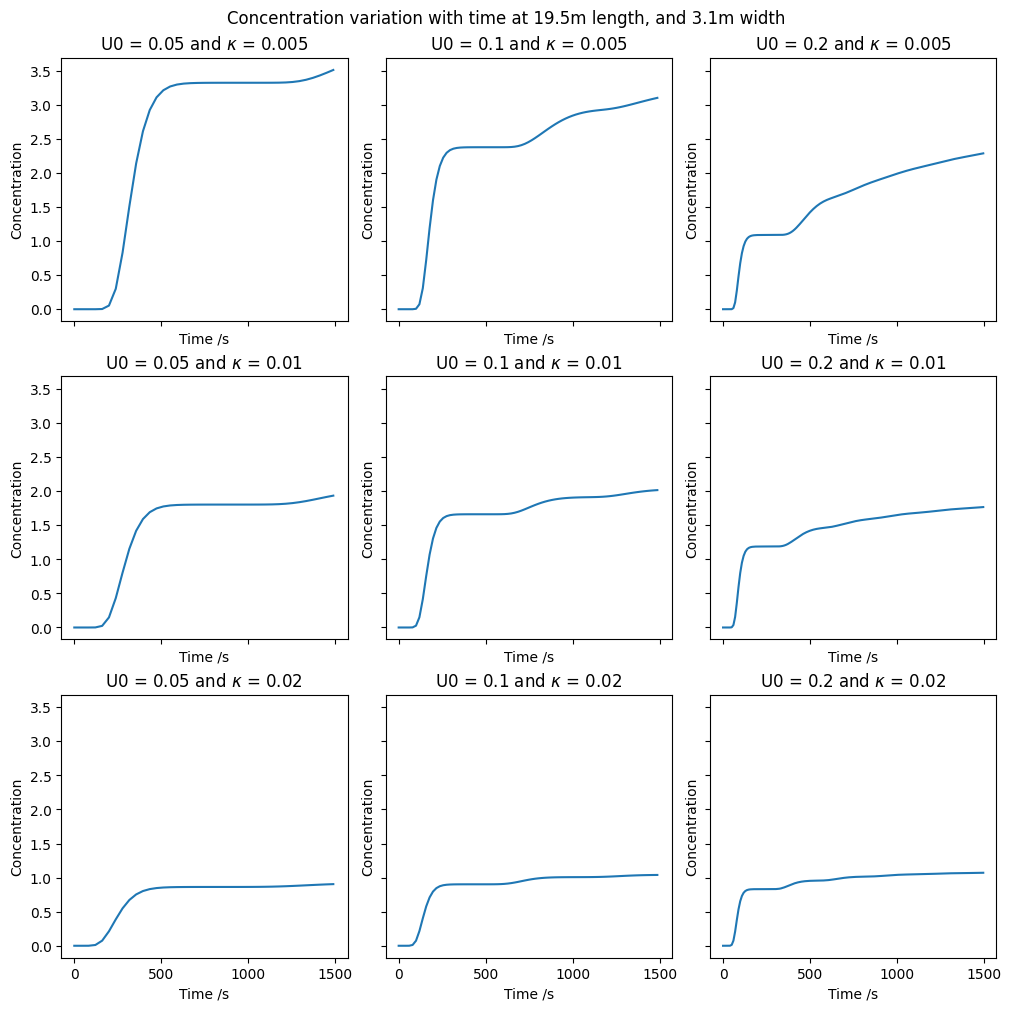

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(10,10),constrained_layout=True, sharex = True, sharey = True)
axs=axs.flatten()
# maximum flow speed is 0.1 and  κ  is 1e-2.

columns= [[0.05,0.5e-2],[0.1, 0.5e-2],[0.2,0.5e-2],[0.05,1e-2],[0.1, 1e-2],[0.2, 1e-2],[0.05,2e-2],[0.1, 2e-2],[0.2,2e-2]]

for i, ax in enumerate(axs):

    # Set parameters
    U0 = columns[i][0] # maximum current speed in m/s       - CHANGE THIS
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    kappa = columns[i][1] # diffusivity in m^2/s           - CHANGE THIS
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    x_bit = 100
    y_bit = 10
    length_bit = x_bit/256 * L
    width_bit = y_bit/32 * w

    axs[i].plot(t_save, c_save[:,x_bit,y_bit])
    axs[i].set_xlabel('Time /s')
    axs[i].set_ylabel('Concentration')

    title = f'U0 = {columns[i][0]} and $\kappa$ = {columns[i][1]}'
    axs[i].set_title(title)

big_title = f'Concentration variation with time at {round(length_bit,1)}m length, and {round(width_bit,1)}m width'
plt.suptitle(big_title)



**My Answer - continued**

Dimensional analysis tells us that $t\approx L^2/\kappa \approx L/U_0$. For $L=10$ (width), $\kappa = 0.01$, and $U_0 = 0.1$, the first option gives a value of 10,000.

For $U_0 = 0.1$, a value of $t=10000$ using the second equation gives $L=1000m$.

This speaks to how rapid the river moves relative to rate of diffusion.

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.